# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Используемые инструменты:**

pandas, numpy, time, skimpy, matplotlib, sklearn, catboost, lightgbm, math.

## Подготовка данных

In [1]:
!pip install skimpy
!pip install -U pandas==1.5.3

  Using cached pandas-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.0
    Uninstalling pandas-2.1.0:
      Successfully uninstalled pandas-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skimpy 0.0.11 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import time
from skimpy import clean_columns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

STATE = 42

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


**Целевой признак**
* Price — цена (евро)

In [5]:
df = clean_columns(df)

In [6]:
df.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
fuel_type,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


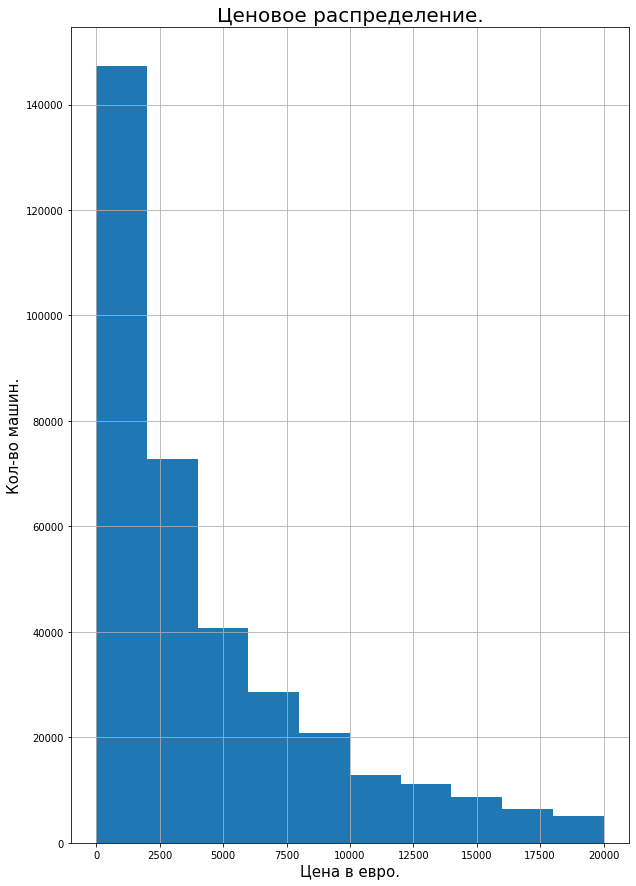

In [8]:
df['price'].plot(kind='hist', figsize=(10, 15), grid=True)
plt.title('Ценовое распределение.', size=20)
plt.xlabel('Цена в евро.', size=15)
plt.ylabel('Кол-во машин.', size=15)
plt.show()

В `price` есть нулевые и около нулевые значения, за нижний ценовой порог мы примем 500 евро. Что касаемо больших значений, то их уберём квантилем.

С помощью столбца `date_created` определим верхний порог регистрации объявления и отсечём в `registration_year` результаты выше. За минимальную `registration_year` будем считать 1960 г., т.к. машины старше наврятли встретятся вне музея.

В `power` уберём машины меньше 50 л.с., а верхний порог отделим квантилем.

In [9]:
np.quantile(df['price'], 0.95)

14600.0

In [10]:
df = df[df['price'] > 499]
df = df[df['price'] < 14601]

In [11]:
print(df['date_created'].min())
print(df['date_created'].max())

2014-03-10 00:00:00
2016-04-07 00:00:00


In [12]:
sort = df['registration_year'].unique()
print(sorted(sort))

[1000, 1001, 1039, 1234, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5911, 6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999]


In [13]:
#df.query('registration_year < 1960') # 422

In [14]:
df = df[df['registration_year'] >= 1960]

In [15]:
#df.query('registration_year > 2016') # 14530

In [16]:
df = df[df['registration_year'] <= 2016]

In [17]:
np.quantile(df['power'], 0.95)

210.0

In [18]:
df = df[df['power'] > 49]
df = df[df['power'] < 205]

In [19]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type           7807
registration_year         0
gearbox                3968
power                     0
model                  8188
kilometer                 0
registration_month        0
fuel_type             11496
brand                     0
repaired              33288
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [20]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(round(missing_value_df, 2))

                    percent_missing
date_crawled                   0.00
price                          0.00
vehicle_type                   3.20
registration_year              0.00
gearbox                        1.63
power                          0.00
model                          3.36
kilometer                      0.00
registration_month             0.00
fuel_type                      4.71
brand                          0.00
repaired                      13.64
date_created                   0.00
number_of_pictures             0.00
postal_code                    0.00
last_seen                      0.00


Для сохранения большего числа данных заполним все пропуски `unknown`.

In [21]:
df = df.fillna({'repaired':'unknown', 
                'fuel_type':'unknown',
                'vehicle_type':'unknown',
                'gearbox':'unknown',
                'model':'unknown',})

In [22]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [23]:
df.duplicated().sum()

3

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.duplicated().sum()

0

In [26]:
df = df.drop(columns=['date_crawled', 
                      'date_created', 
                      'number_of_pictures',
                      'last_seen',
                      'postal_code',
                      'registration_month'])

In [27]:
#df.duplicated().sum() #34025
df.drop_duplicates(inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209983 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              209983 non-null  int64 
 1   vehicle_type       209983 non-null  object
 2   registration_year  209983 non-null  int64 
 3   gearbox            209983 non-null  object
 4   power              209983 non-null  int64 
 5   model              209983 non-null  object
 6   kilometer          209983 non-null  int64 
 7   fuel_type          209983 non-null  object
 8   brand              209983 non-null  object
 9   repaired           209983 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.6+ MB


На этапе подготовки данных мы изучили и обработали файл с данными сервиса по продаже автомобилей. Сам файл состоял из 354369 наблюдений и 16 признаков. В ходе преобработки данных мы убрали нулевые и около нулевые значения целевого признака, убрали слишком ранние годы, посчитав их наличие опечаткой/маловероятным, ограничили мощность двигателя 50 и 400 л.с., заполнили все пропуски и удалили неинформативные признаки. После проведённой работы у нас осталось 209983 наблюдений и 10 признаков, удалили 144386 наблюдений и 6 признаков.

## Обучение моделей

In [29]:
x = df.drop(['price'], axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,test_size=0.4, random_state=STATE)
x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, y_test,test_size=0.5,random_state=STATE)

print('Размер обущающей выборки:')
print(x_train.shape)
print(y_train.shape)
print('*' * 100)
print('Размер валидационной выборки:')
print(x_valid.shape)
print(y_valid.shape)
print('*' * 100)
print('Размер тестовой выборки:')
print(x_test.shape)
print(y_test.shape)

Размер обущающей выборки:
(125989, 9)
(125989,)
****************************************************************************************************
Размер валидационной выборки:
(41997, 9)
(41997,)
****************************************************************************************************
Размер тестовой выборки:
(41997, 9)
(41997,)


In [30]:
col = x_train.select_dtypes(include='object').columns.to_list()
print(col)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


In [31]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

x_train[col] = enc.fit_transform(x_train[col])
x_test[col] = enc.transform(x_test[col])
x_valid[col] = enc.transform(x_valid[col])

#print(x_train.head(5))
#print(x_test.head(5))
#print(x_valid.head(5))

In [32]:
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()

In [33]:
x_train[numeric] = scaler.fit_transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])

print(x_train.head(5))
print(x_test.head(5))
print(x_valid.head(5))

        vehicle_type  registration_year  gearbox     power  model  kilometer  \
60481            7.0          -0.470057      1.0 -1.402134  168.0   0.596087   
260529           8.0          -0.632311      1.0  1.493847   15.0   0.596087   
309255           4.0           0.341208      1.0 -0.612321  161.0   0.596087   
222442           0.0           0.016702      2.0 -0.322723  145.0   0.596087   
179515           5.0           1.639233      1.0 -1.165190  161.0  -3.033354   

        fuel_type  brand  repaired  
60481         6.0   38.0       1.0  
260529        4.0    2.0       0.0  
309255        2.0   35.0       0.0  
222442        6.0   24.0       0.0  
179515        6.0   24.0       0.0  
        vehicle_type  registration_year  gearbox     power  model  kilometer  \
272016           4.0          -0.470057      1.0  0.809342  159.0   0.596087   
9108             5.0          -0.794564      1.0 -1.665405  168.0   0.596087   
98398            4.0          -0.632311      1.0 -0.82293

In [34]:
models_rmse = pd.DataFrame(columns = ['Модель', 'RMSE', 'Время обучения', 'Время предсказания'])

In [35]:
%%time

best_depth = 0
best_est = 0
best_rmse = 2500

for est in range(20, 60, 10):
    for depth in range(5,7):    
        model = RandomForestRegressor(random_state=STATE, max_depth=depth, n_estimators=est)
        start_time = time.time()
        model.fit(x_train, y_train)
        time_rfc = time.time() - start_time
        start_time = time.time()
        predict = model.predict(x_valid)
        time_pred = time.time() - start_time
        rmse = sqrt(mean_squared_error(y_valid, predict))
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_est = est
        
print('Результаты модели Random Forest Regressor при max_depth =', best_depth, 'и n_estimators =',best_est)
print('RMSE: {:.3f}'.format(best_rmse))
models_rmse = models_rmse.append({'Модель':'RandomForestRegressor', 
                                  'RMSE':round(best_rmse, 3), 
                                  'Время обучения':time_rfc, 
                                  'Время предсказания':time_pred}, ignore_index=True)

Результаты модели Random Forest Regressor при max_depth = 6 и n_estimators = 50
RMSE: 1759.751
CPU times: user 28.6 s, sys: 0 ns, total: 28.6 s
Wall time: 28.6 s


In [36]:
%%time

best_rmse_lgbm = 2500
best_depth_lgbm = 0
rate_lgbm = 0.5

for depth in range(5,7):
    model_lgmb = LGBMRegressor(learning_rate=rate_lgbm, depth=depth, random_state=STATE)
    start_time = time.time()
    model_lgmb.fit(x_train, y_train)
    time_lgbm = time.time() - start_time
    start_time = time.time()
    predict = model_lgmb.predict(x_valid)
    time_pred_lgbm = time.time() - start_time
    rmse = sqrt(mean_squared_error(y_valid, predict))
    if rmse < best_rmse_lgbm:
        best_rmse_lgbm = rmse
        best_depth_lgbm = depth
        
print('Результаты модели Light Gradient Boosted Machine при max_depth =', best_depth_lgbm, 'и rate =', rate_lgbm)
print('RMSE: {:.3f}'.format(best_rmse_lgbm))
models_rmse = models_rmse.append({'Модель':'LGBMRegressor', 
                                  'RMSE':round(best_rmse_lgbm, 3), 
                                  'Время обучения':time_lgbm, 
                                  'Время предсказания':time_pred_lgbm}, ignore_index=True)

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
Результаты модели Light Gradient Boosted Machine при max_depth = 5 и rate = 0.5
RMSE: 1305.783
CPU times: user 2min 37s, sys: 946 ms, total: 2min 38s
Wall time: 2min 39s


In [37]:
%%time

best_rmse_cbr = 2500
best_depth_cbr = 0
rate_cbr = 0.5

for depth in range(5,7):
    model_cbr = CatBoostRegressor(learning_rate=rate_cbr, depth=depth, random_state=STATE, silent=True)
    start_time = time.time()
    model_cbr.fit(x_train, y_train)
    time_cbr = time.time() - start_time
    start_time = time.time()
    predict = model_cbr.predict(x_valid)
    time_pred_cbr = time.time() - start_time
    rmse = sqrt(mean_squared_error(y_valid, predict))
    if rmse < best_rmse_cbr:
        best_rmse_cbr = rmse
        best_depth_cbr = depth
                                  
print('Результаты модели Cat Boost Regressor при max_depth =', best_depth_cbr, 'и rate =', rate_cbr)
print('RMSE: {:.3f}'.format(best_rmse_cbr))
models_rmse = models_rmse.append({'Модель':'CatBoostRegressor', 
                                  'RMSE':round(best_rmse_cbr, 3), 
                                  'Время обучения':time_cbr, 
                                  'Время предсказания':time_pred_cbr}, ignore_index=True)

Результаты модели Cat Boost Regressor при max_depth = 6 и rate = 0.5
RMSE: 1275.025
CPU times: user 33.4 s, sys: 367 ms, total: 33.7 s
Wall time: 38.6 s


На этом этапе мы отделили цлевой признак признак и разбили на выборки в соотношении 3:1:1. Обработали категориальные признаки с помощью класса OHE из sklearn. Обучили 3 модели: RFR, LGBMR и CBR. Все модели отвечают требованиям заказчика. Результаты наших моделей, а именно rmse, время обучения модели и время предсказания мы сохранили в отдельную таблицу. В следующем пункте сравним их и на лучшей модели используем тестовую выборку.

## Анализ моделей

In [38]:
models_rmse.sort_values(by='RMSE')

,Модель,RMSE,Время обучения,Время предсказания
2,CatBoostRegressor,1275.025,18.888339,0.044362
1,LGBMRegressor,1305.783,2.701468,0.293221
0,RandomForestRegressor,1759.751,5.462544,0.106409


Модели градиентного бустинга однозначно лучше себя показали. CBR выдала самый лучший результат rmse и время предсказания, но по времени обучения она уступает LGBMR несколько раз. Но если бы данных было в десятки и сотни раз больше, что привело бы к сильному росту потерь, а для бизнеса это плохо, то выбор полностью падает на CBR с параметрами rate=0.5 и depth=6. На ней мы и используем тестовую выборку.

In [39]:
%%time

rate_cbr_test = 0.5
depth = 6


model_cbr_test = CatBoostRegressor(learning_rate=rate_cbr_test, depth=depth, random_state=STATE, silent=True)
model_cbr_test.fit(x_train, y_train)
predict_test = model_cbr_test.predict(x_test)
rmse_cbr_test = sqrt(mean_squared_error(y_test, predict_test))
   
print('Результаты модели Cat Boost Regressor при max_depth =', depth, 'и rate =', rate_cbr_test)
print('RMSE: {:.3f}'.format(rmse_cbr_test))

Результаты модели Cat Boost Regressor при max_depth = 6 и rate = 0.5
RMSE: 1272.973
CPU times: user 17.9 s, sys: 127 ms, total: 18 s
Wall time: 19.3 s


In [40]:
%%time

model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(x_train, y_train)
predict = model_dummy.predict(x_valid)
rmse_dummy = sqrt(mean_squared_error(y_valid, predict))


print('Результаты модели Dummy Regressor:')
print('RMSE: {:.3f}'.format(rmse_dummy))

Результаты модели Dummy Regressor:
RMSE: 3653.159
CPU times: user 0 ns, sys: 4.82 ms, total: 4.82 ms
Wall time: 3.4 ms


## Вывод.

В этом исследовании нашим заказчиком является сервис по продаже автомобилей с пробегом «Не бит, не крашен». Для них нужно построить модель для определения стоимости автомобиля.

Критерии оценки заказчика:

* качество предсказания;
* скорость предсказания;
* время обучения.

Нам были предоставлены данные, состоящих из анкет пользователей, продающих машины за период 2014-2016гг. На этапе предобработки данных мы очистили наши данные от пропущенных значений, дубликатов и аномально малых/больших значений, исключив около 150000 объявлений. Выявили и удалили неинформативные для дальнейшего обучения признаки. Масштабировали категориальные признаки и разбили данные на выборки. Обучили и сравнили 3 модели. По результатам исследования выявили лучшую модель, а именно CatBoostRegressor. На этой модели с этими же параметрами мы сделали предсказания на тестовой выборке. Сравнили нашу модель с константной моделью, проверку на адекватность модель прошла.

Для более качественного результата было бы неплохо использовать изначальное количество наблюдений, но из-за некорректного заполнения некоторых признаков, использовать их мы не могли. Такие признаки как мощность и год выпуска авто (возможно мы ошиблись интерпретировав так год регистрации авто; здесь неплохо было бы в этом разобраться) являются практически самыми выжными (после цены) при выборе авто, а большую часть данных мы урезали именно из-за них. 